In [18]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
threshold = 1
dataset = 'Human_DLPFC'
samples = ["151507","151508","151509","151510","151669","151670","151671","151672","151673","151674","151675","151676"]

In [20]:
# threshold = 1
# dataset = 'others'
# samples = ["bcdc_ffpe"]

In [21]:
# threshold = 1
# dataset = 'others'
# samples = ['Melanoma']

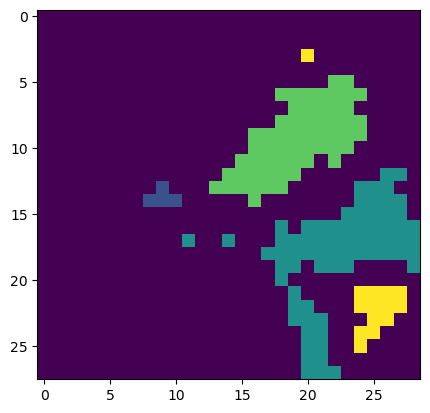

In [22]:
for sample in samples:
    cnt_file_path = f'./../Data/{dataset}/{sample}/reading_h5/'
    mclust_result_csv = f'./../Data/{dataset}/{sample}/mclust_result.csv'
    if sample == 'Melanoma':
        # mclust_result_csv = f'./../Data/{dataset}/{sample}/mclust_scribble-3_cluster.csv'
        mclust_result_csv = f'./../Data/{dataset}/{sample}/mclust_scribble.csv'

    if dataset == 'Human_DLPFC':
        adata = sc.read_visium(cnt_file_path, count_file=f'{sample}_filtered_feature_bc_matrix.h5')
    else:
        adata = sc.read(cnt_file_path+f'{sample}_filtered_feature_bc_matrix.h5')


    arr_row,arr_col = adata.obs['array_row'],adata.obs['array_col']

    # define 2d grid of string as barcode
    barcode_grid = np.empty((arr_row.max()+1,arr_col.max()+1),dtype=object)
    barcode_grid[arr_row,arr_col] = arr_row.index

    mclust_result = pd.read_csv(mclust_result_csv,index_col=0)

    mclust_backbone = pd.DataFrame(index=mclust_result.index)
    mclust_backbone['cluster.init'] = None

    def find_neighbouring_clusters(barcode_grid,mclust_result,i_row,i_col):
        neighbours_clusters = []

        if barcode_grid[i_row,i_col] is None:
            return neighbours_clusters
        
        neighbours = [[i_row,i_col-2],[i_row,i_col+2],[i_row-1,i_col-1],
        [i_row-1,i_col+1],[i_row+1,i_col-1],[i_row+1,i_col+1]]

        if sample == 'Melanoma':
            neighbours = [[i_row,i_col-1],[i_row,i_col+1],[i_row-1,i_col],[i_row+1,i_col]]

        for x,y in neighbours:
            if x<0 or y<0 or x>=barcode_grid.shape[0] or y>=barcode_grid.shape[1]:
                continue
            if barcode_grid[x,y] is None:
                continue
            neighbours_clusters.append(mclust_result['cluster.init'].loc[barcode_grid[x,y]])
        return neighbours_clusters

    for i in range(barcode_grid.shape[0]):
        for j in range(barcode_grid.shape[1]):
            if barcode_grid[i,j] is not None:
                cluster_this = mclust_result['cluster.init'].loc[barcode_grid[i,j]]
                neighbours_clusters = find_neighbouring_clusters(barcode_grid,mclust_result,i,j)

                if len(neighbours_clusters) == 0:
                    continue
                else :
                    correct_prop = np.where(np.array(neighbours_clusters)==cluster_this)[0].shape[0]/len(neighbours_clusters)
                    if correct_prop >= threshold:
                        mclust_backbone['cluster.init'].loc[barcode_grid[i,j]] = cluster_this

    mclust_backbone.to_csv(f'./../Data/{dataset}/{sample}/mclust_backbone.csv')
    mclust_backbone_matrix = np.zeros_like(barcode_grid,dtype=float)

    for i in range(barcode_grid.shape[0]):
        for j in range(barcode_grid.shape[1]):
            if barcode_grid[i,j] is not None:
                if mclust_backbone['cluster.init'].loc[barcode_grid[i,j]] is not None:
                    mclust_backbone_matrix[i,j] = float(mclust_backbone['cluster.init'].loc[barcode_grid[i,j]])+1

    plt.imshow(mclust_backbone_matrix*10 + 50)
